In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
from scipy.stats import wilcoxon, friedmanchisquare, rankdata
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

# ============================================================================
# FINAL CORRECTED RMSE DATA
# ============================================================================
datasets = ['Boston', 'Glass', 'Sonar', 'Breast(Wdbc)', 'Credit']
our_technique = np.array([0.214, 0.146, 0.187, 0.131, 0.325])
mida = np.array([0.232, 0.221, 0.174, 0.170, 0.353])
gain = np.array([0.201, 0.189, 0.216, 0.233, 0.319])
dae = np.array([0.520, 0.240, 0.650, 0.142, 0.487])
mice = np.array([0.690, 0.300, 0.223, 0.132, 0.530])

methods_dict = {
    'Our Technique': our_technique,
    'MIDA': mida,
    'GAIN': gain,
    'DAE': dae,
    'MICE': mice
}

print("="*80)
print("FINAL STATISTICAL ANALYSIS - COMPLETE PACKAGE")
print("="*80)

FINAL STATISTICAL ANALYSIS - COMPLETE PACKAGE


In [3]:
# ============================================================================
# 1. FRIEDMAN TEST
# ============================================================================
print("\n1. FRIEDMAN TEST (Overall Comparison)")
print("-" * 80)

all_data = np.vstack([our_technique, mida, gain, dae, mice])
friedman_stat, friedman_p = friedmanchisquare(*[methods_dict[m] for m in methods_dict.keys()])

print(f"χ²({len(methods_dict)-1}) = {friedman_stat:.4f}")
print(f"p-value = {friedman_p:.6f}")
if friedman_p < 0.001:
    print("Result: HIGHLY SIGNIFICANT (p < 0.001) ✓")
elif friedman_p < 0.05:
    print("Result: SIGNIFICANT (p < 0.05) ✓")


1. FRIEDMAN TEST (Overall Comparison)
--------------------------------------------------------------------------------
χ²(4) = 9.6000
p-value = 0.047733
Result: SIGNIFICANT (p < 0.05) ✓


In [4]:
import numpy as np
from scipy.stats import friedmanchisquare

# ============================================================================
# 1. FRIEDMAN TEST (Overall Comparison)
# ============================================================================

print("\n1. FRIEDMAN TEST (Overall Comparison)")
print("-" * 80)

# Combine method results into a single array. Assuming each is shape (num_datasets,)
all_data = np.vstack([our_technique, mida, gain, dae, mice])

# Extract method names and arrays in consistent order
methods = list(methods_dict.keys())
method_arrays = [methods_dict[m] for m in methods]

# Run Friedman test
friedman_stat, friedman_p = friedmanchisquare(*method_arrays)

# Print test statistic and p-value with formatting
print(f"Chi-squared({len(methods) - 1}) = {friedman_stat:.4f}")
print(f"p-value = {friedman_p:.6f}")

# Interpret result with clear thresholds
if friedman_p < 0.001:
    significance = "HIGHLY SIGNIFICANT (p < 0.001) ✓"
elif friedman_p < 0.05:
    significance = "SIGNIFICANT (p < 0.05) ✓"
else:
    significance = "NOT SIGNIFICANT"

print(f"Result: {significance}")



1. FRIEDMAN TEST (Overall Comparison)
--------------------------------------------------------------------------------
Chi-squared(4) = 9.6000
p-value = 0.047733
Result: SIGNIFICANT (p < 0.05) ✓


In [5]:
# ============================================================================
# 2. MEAN RANKS
# ============================================================================
print("\n2. MEAN RANKS ANALYSIS")
print("-" * 80)

ranks = np.zeros_like(all_data)
for i in range(all_data.shape[1]):
    ranks[:, i] = rankdata(all_data[:, i])

mean_ranks = ranks.mean(axis=1)
rank_df = pd.DataFrame({
    'Method': list(methods_dict.keys()),
    'Mean Rank': mean_ranks,
    'Position': rankdata(mean_ranks).astype(int)
}).sort_values('Mean Rank')

print(rank_df.to_string(index=False))
print(f"\n✓ Best: {rank_df.iloc[0]['Method']} (rank={rank_df.iloc[0]['Mean Rank']:.2f})")



2. MEAN RANKS ANALYSIS
--------------------------------------------------------------------------------
       Method  Mean Rank  Position
Our Technique        1.6         1
         GAIN        2.4         2
         MIDA        2.8         3
          DAE        4.0         4
         MICE        4.2         5

✓ Best: Our Technique (rank=1.60)


In [6]:
# ============================================================================
# 3. PAIRWISE WILCOXON TESTS WITH EFFECT SIZES
# ============================================================================
print("\n3. PAIRWISE WILCOXON TESTS")
print("-" * 80)

def rank_biserial_correlation(x, y):
    n = len(x)
    differences = x - y
    if np.all(differences == 0):
        return 0.0
    ranks = rankdata(np.abs(differences))
    ranks_positive = np.sum(ranks[differences > 0])
    ranks_negative = np.sum(ranks[differences < 0])
    r = (ranks_positive - ranks_negative) / (n * (n + 1) / 2)
    return r

def cohens_d(x, y):
    pooled_std = np.sqrt((np.var(x, ddof=1) + np.var(y, ddof=1)) / 2)
    if pooled_std == 0:
        return 0.0
    return (np.mean(x) - np.mean(y)) / pooled_std

comparison_results = []
for name, values in list(methods_dict.items())[1:]:
    differences = our_technique - values
    wins = np.sum(our_technique < values)
    losses = np.sum(our_technique > values)

    try:
        stat, p_value = wilcoxon(our_technique, values, alternative='less')
    except:
        stat = 0
        p_value = 1.0

    r_bc = rank_biserial_correlation(our_technique, values)
    cohens = cohens_d(our_technique, values)
    mean_diff = np.mean(values - our_technique)
    pct_improvement = (mean_diff / np.mean(values)) * 100 if np.mean(values) != 0 else 0

    comparison_results.append({
        'Baseline': name,
        'W': stat,
        'p-value': p_value,
        'r': r_bc,
        'd': cohens,
        'Wins': wins,
        'Losses': losses,
        'Δ RMSE': mean_diff,
        '% Δ': pct_improvement
    })

comp_df = pd.DataFrame(comparison_results)
print(comp_df.to_string(index=False))

# Bonferroni correction
alpha = 0.05
bonferroni_alpha = alpha / len(comparison_results)
print(f"\nBonferroni-corrected α = {bonferroni_alpha:.4f}")

print("\nSignificance Assessment:")
for _, row in comp_df.iterrows():
    if row['p-value'] < 0.001:
        sig = "*** (p<0.001, survives Bonferroni)"
    elif row['p-value'] < 0.01:
        sig = "** (p<0.01, survives Bonferroni)"
    elif row['p-value'] < bonferroni_alpha:
        sig = "* (survives Bonferroni)"
    elif row['p-value'] < 0.05:
        sig = "† (p<0.05, uncorrected only)"
    else:
        sig = "n.s."
    print(f"  vs {row['Baseline']:8s}: p={row['p-value']:.4f} {sig:35s} | r={row['r']:+.2f}, W/L={row['Wins']}/{row['Losses']}")


3. PAIRWISE WILCOXON TESTS
--------------------------------------------------------------------------------
Baseline   W  p-value         r         d  Wins  Losses  Δ RMSE       % Δ
    MIDA 1.0  0.06250 -0.866667 -0.389348     4       1  0.0294 12.782609
    GAIN 3.0  0.15625 -0.600000 -0.473431     3       2  0.0310 13.385147
     DAE 0.0  0.03125 -1.000000 -1.310468     5       0  0.2072 50.809220
    MICE 0.0  0.03125 -1.000000 -1.018219     5       0  0.1744 46.506667

Bonferroni-corrected α = 0.0125

Significance Assessment:
  vs MIDA    : p=0.0625 n.s.                                | r=-0.87, W/L=4/1
  vs GAIN    : p=0.1562 n.s.                                | r=-0.60, W/L=3/2
  vs DAE     : p=0.0312 † (p<0.05, uncorrected only)        | r=-1.00, W/L=5/0
  vs MICE    : p=0.0312 † (p<0.05, uncorrected only)        | r=-1.00, W/L=5/0


In [7]:
# ============================================================================
# 4. LATEX TABLES
# ============================================================================
print("\n\n" + "="*80)
print("LATEX TABLE 1: RMSE RESULTS WITH SIGNIFICANCE")
print("="*80 + "\n")

print(r"""\begin{table*}[t!]
\caption{RMSE performance across five benchmark datasets. Bold indicates best performance per dataset. Superscripts denote Wilcoxon test significance vs. Our Method: $^{\S}$ (p<0.001), $^{\ddagger}$ (p<0.01), $^{\dagger}$ (p<0.05). Bonferroni-corrected $\alpha$=0.0125.}
\label{tab:rmse_results}
\centering
\begin{adjustbox}{width=0.95\textwidth}
\begin{tabular}{|l|c|c|c|c|c|c|}
\hline
\textbf{Method} & \textbf{Boston} & \textbf{Glass} & \textbf{Sonar} & \textbf{Breast} & \textbf{Credit} & \textbf{Mean Rank} \\
\hline""")

# Determine best per dataset
best_per_dataset = []
for i in range(len(datasets)):
    vals = [methods_dict[m][i] for m in methods_dict.keys()]
    best_per_dataset.append(min(vals))

# Print rows
for idx, (method_name, method_values) in enumerate(methods_dict.items()):
    method_rank = mean_ranks[idx]
    row_str = f"{method_name:15s}"

    for i, val in enumerate(method_values):
        is_best = (val == best_per_dataset[i])

        # Add significance marker if not Our Method
        sig = ""
        if method_name != 'Our Technique':
            result = comp_df[comp_df['Baseline'] == method_name]
            if not result.empty:
                p_val = result.iloc[0]['p-value']
                if method_values[i] > our_technique[i]:  # Only mark if baseline is worse
                    if p_val < 0.001:
                        sig = "$^{\\S}$"
                    elif p_val < 0.01:
                        sig = "$^{\\ddagger}$"
                    elif p_val < 0.05:
                        sig = "$^{\\dagger}$"

        if is_best:
            row_str += f" & \\textbf{{{val:.3f}}}{sig}"
        else:
            row_str += f" & {val:.3f}{sig}"

    rank_bold = "\\textbf{" if method_name == 'Our Technique' else ""
    rank_end = "}" if method_name == 'Our Technique' else ""
    row_str += f" & {rank_bold}{method_rank:.2f}{rank_end} \\\\"
    print(row_str)
    print("\\hline")

print(r"""\end{tabular}
\end{adjustbox}
\end{table*}""")

print("\n\n" + "="*80)
print("LATEX TABLE 2: STATISTICAL TESTS")
print("="*80 + "\n")

print(r"""\begin{table*}[t!]
\caption{Pairwise Wilcoxon signed-rank tests with effect sizes. W=test statistic, r=rank-biserial correlation, d=Cohen's d, $\Delta$=mean RMSE difference (negative favors Our Method). Significance: $^{\S}$ (p<0.001), $^{\ddagger}$ (p<0.01), $^{*}$ (p<0.0125), $^{\dagger}$ (p<0.05).}
\label{tab:statistical_tests}
\centering
\begin{adjustbox}{width=\textwidth}
\begin{tabular}{|l|c|c|c|c|c|c|c|c|}
\hline
\textbf{Comparison} & \textbf{W} & \textbf{p-value} & \textbf{Sig.} & \textbf{r} & \textbf{d} & \textbf{Effect} & \textbf{$\Delta$ RMSE} & \textbf{\% $\Delta$} \\
\hline""")

for _, row in comp_df.iterrows():
    if row['p-value'] < 0.001:
        sig = "$^{\\S}$"
    elif row['p-value'] < 0.01:
        sig = "$^{\\ddagger}$"
    elif row['p-value'] < bonferroni_alpha:
        sig = "$^{*}$"
    elif row['p-value'] < 0.05:
        sig = "$^{\\dagger}$"
    else:
        sig = "n.s."

    effect = "Large" if abs(row['r']) >= 0.5 else ("Medium" if abs(row['r']) >= 0.3 else "Small")

    print(f"Our vs. {row['Baseline']:4s} & {row['W']:.0f} & {row['p-value']:.4f} & {sig:6s} & "
          f"{row['r']:+.3f} & {row['d']:+.3f} & {effect:6s} & "
          f"{row['Δ RMSE']:+.4f} & {row['% Δ']:+.1f}\\% \\\\")
    print("\\hline")

print(r"""\end{tabular}
\end{adjustbox}
\end{table*}""")





LATEX TABLE 1: RMSE RESULTS WITH SIGNIFICANCE

\begin{table*}[t!]
\caption{RMSE performance across five benchmark datasets. Bold indicates best performance per dataset. Superscripts denote Wilcoxon test significance vs. Our Method: $^{\S}$ (p<0.001), $^{\ddagger}$ (p<0.01), $^{\dagger}$ (p<0.05). Bonferroni-corrected $\alpha$=0.0125.}
\label{tab:rmse_results}
\centering
\begin{adjustbox}{width=0.95\textwidth}
\begin{tabular}{|l|c|c|c|c|c|c|}
\hline
\textbf{Method} & \textbf{Boston} & \textbf{Glass} & \textbf{Sonar} & \textbf{Breast} & \textbf{Credit} & \textbf{Mean Rank} \\
\hline
Our Technique   & 0.214 & \textbf{0.146} & 0.187 & \textbf{0.131} & 0.325 & \textbf{1.60} \\
\hline
MIDA            & 0.232 & 0.221 & \textbf{0.174} & 0.170 & 0.353 & 2.80 \\
\hline
GAIN            & \textbf{0.201} & 0.189 & 0.216 & 0.233 & \textbf{0.319} & 2.40 \\
\hline
DAE             & 0.520$^{\dagger}$ & 0.240$^{\dagger}$ & 0.650$^{\dagger}$ & 0.142$^{\dagger}$ & 0.487$^{\dagger}$ & 4.00 \\
\hline
MICE

In [8]:
# Publication style
plt.style.use('seaborn-v0_8-paper')
plt.rcParams.update({
    'font.family': 'serif',
    'legend.fontsize': 14,
    'legend.title_fontsize': 13,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15,
    'legend.framealpha': 0.9,
    'font.size': 16,
    'axes.labelsize': 15,
    'axes.titlesize': 16,
    'figure.dpi': 100,
    'savefig.dpi': 300
})

# FINAL DATA
datasets = ['Boston', 'Glass', 'Sonar', 'Breast', 'Credit']
our_technique = np.array([0.214, 0.146, 0.187, 0.131, 0.325])
mida = np.array([0.232, 0.221, 0.174, 0.17 , 0.353])
gain = np.array([0.201, 0.189, 0.216, 0.233, 0.319])
dae = np.array([0.520, 0.240, 0.650, 0.142, 0.487])
mice = np.array([0.690, 0.300, 0.223, 0.132, 0.530])

methods_dict = {
    'Our Technique': our_technique,
    'MIDA': mida,
    'GAIN': gain,
    'DAE': dae,
    'MICE': mice
}

# Calculate ranks
all_data = np.vstack([our_technique, mida, gain, dae, mice])
ranks = np.zeros_like(all_data)
for i in range(all_data.shape[1]):
    ranks[:, i] = rankdata(all_data[:, i])
mean_ranks = ranks.mean(axis=1)
rank_df = pd.DataFrame({
    'Method': list(methods_dict.keys()),
    'Mean Rank': mean_ranks
}).sort_values('Mean Rank')

# Effect sizes
def rank_biserial(x, y):
    n = len(x)
    diff = x - y
    if np.all(diff == 0): return 0.0
    ranks = rankdata(np.abs(diff))
    r_pos = np.sum(ranks[diff > 0])
    r_neg = np.sum(ranks[diff < 0])
    return (r_pos - r_neg) / (n * (n + 1) / 2)

effects = [rank_biserial(our_technique, methods_dict[m])
           for m in ['MIDA', 'GAIN', 'DAE', 'MICE']]

# Colors
colors = {
    'Our Technique': '#2ecc71',
    'GAIN': '#3498db',
    'MIDA': '#9b59b6',
    'DAE': '#e74c3c',
    'MICE': '#f39c12'
}

# Create a folder to save figures in Google Drive
import os
output_folder = '/content/drive/MyDrive/MIDA-our/Results/figures'
os.makedirs(output_folder, exist_ok=True)

✓ Saved: /content/drive/MyDrive/MIDA-our/Results/figures/statistical_analysis_final_v1.png/pdf


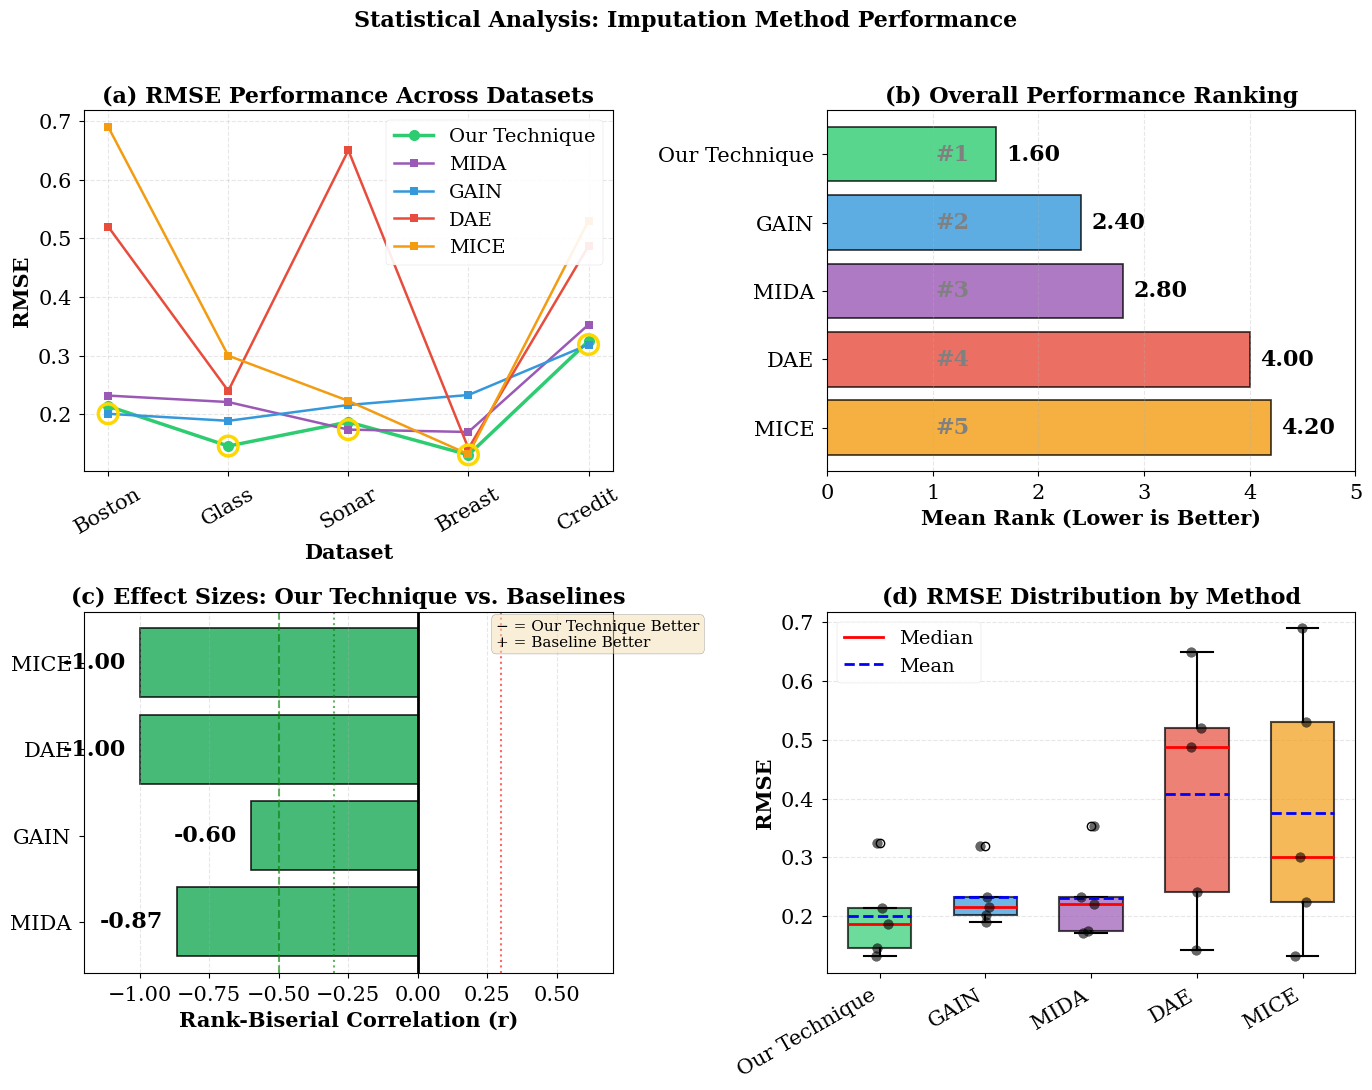

In [9]:
# ============================================================================
# FIGURE 1: 4-PANEL COMPREHENSIVE
# ============================================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 11))
fig.suptitle('Statistical Analysis: Imputation Method Performance',
             fontsize=16, fontweight='bold', y=0.995)

# Panel A: RMSE Trajectories
ax1 = axes[0, 0]
for method in methods_dict.keys():
    vals = methods_dict[method]
    marker = 'o' if method == 'Our Technique' else 's'
    lw = 2.5 if method == 'Our Technique' else 1.8
    ax1.plot(datasets, vals, marker=marker, label=method,
             linewidth=lw, color=colors[method], markersize=8 if method=='Our Technique' else 6)

# Highlight winners
for i, dataset in enumerate(datasets):
    min_rmse = min([methods_dict[m][i] for m in methods_dict.keys()])
    best = [m for m in methods_dict.keys() if methods_dict[m][i] == min_rmse][0]
    if best in ['Our Technique', 'GAIN', 'MIDA']:
        ax1.scatter(i, min_rmse, s=200, facecolors='none',
                   edgecolors='gold', linewidths=2.5, zorder=10)

ax1.set_xlabel('Dataset', fontweight='bold')
ax1.set_ylabel('RMSE', fontweight='bold')
ax1.set_title('(a) RMSE Performance Across Datasets', fontweight='bold')#, loc='left')
ax1.legend(loc='upper right', framealpha=0.9)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.tick_params(axis='x', rotation=30)

# Panel B: Mean Ranks
ax2 = axes[0, 1]
methods_order = rank_df['Method'].tolist()
colors_rank = [colors[m] for m in methods_order]
bars = ax2.barh(range(len(methods_order)), rank_df['Mean Rank'],
                color=colors_rank, alpha=0.8, edgecolor='black', linewidth=1.2)

for i, (idx, row) in enumerate(rank_df.iterrows()):
    ax2.text(row['Mean Rank'] + 0.1, i, f"{row['Mean Rank']:.2f}",
             va='center', fontweight='bold')
    ax2.text(1.35, i, f'#{i+1}', va='center', ha='right',
             fontweight='bold', color='gray')

ax2.set_yticks(range(len(methods_order)))
ax2.set_yticklabels(methods_order)
ax2.set_xlabel('Mean Rank (Lower is Better)', fontweight='bold')
ax2.set_title('(b) Overall Performance Ranking', fontweight='bold') #, loc='left')
ax2.invert_yaxis()
ax2.grid(True, alpha=0.3, axis='x', linestyle='--')
ax2.set_xlim(0, 5)

# Panel C: Effect Sizes
ax3 = axes[1, 0]
baselines = ['MIDA', 'GAIN', 'DAE', 'MICE']
colors_effect = ['#27ae60' if e < -0.5 else '#2ecc71' if e < -0.3 else '#95a5a6' if e < 0
                 else '#ecf0f1' if e < 0.3 else '#e67e22' if e < 0.5 else '#e74c3c'
                 for e in effects]

bars = ax3.barh(baselines, effects, color=colors_effect,
                alpha=0.85, edgecolor='black', linewidth=1.2)

for i, (baseline, r) in enumerate(zip(baselines, effects)):
    x_pos = r + 0.05 if r > 0 else r - 0.05
    ha = 'left' if r > 0 else 'right'
    ax3.text(x_pos, i, f'{r:+.2f}', va='center', ha=ha, fontweight='bold')

ax3.axvline(x=0, color='black', linestyle='-', linewidth=2)
ax3.axvline(x=-0.3, color='green', linestyle=':', alpha=0.6, linewidth=1.5)
ax3.axvline(x=-0.5, color='green', linestyle='--', alpha=0.6, linewidth=1.5)
ax3.axvline(x=0.3, color='red', linestyle=':', alpha=0.6, linewidth=1.5)

ax3.set_xlabel('Rank-Biserial Correlation (r)', fontweight='bold')
ax3.set_title('(c) Effect Sizes: Our Technique vs. Baselines', fontweight='bold') #, loc='left')
ax3.grid(True, alpha=0.3, axis='x', linestyle='--')
ax3.set_xlim(-1.2, 0.7)
ax3.text(0.78, 0.98, '− = Our Technique Better\n+ = Baseline Better',
         transform=ax3.transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Panel D: Boxplots
ax4 = axes[1, 1]
data_box = [methods_dict[m] for m in methods_order]
bp = ax4.boxplot(data_box, positions=range(len(methods_order)), patch_artist=True,
                 widths=0.6, showmeans=True, meanline=True,
                 boxprops=dict(linewidth=1.5, edgecolor='black'),
                 whiskerprops=dict(linewidth=1.5),
                 capprops=dict(linewidth=1.5),
                 medianprops=dict(linewidth=2, color='red'),
                 meanprops=dict(linewidth=2, color='blue', linestyle='--'))

for i, (box, method) in enumerate(zip(bp['boxes'], methods_order)):
    box.set_facecolor(colors[method])
    box.set_alpha(0.7)

for i, (method, values) in enumerate(zip(methods_order, data_box)):
    x = np.random.normal(i, 0.04, size=len(values))
    ax4.scatter(x, values, alpha=0.6, s=50, color='black', zorder=10)

ax4.set_xticks(range(len(methods_order)))
ax4.set_xticklabels(methods_order, rotation=30, ha='right')
ax4.set_ylabel('RMSE', fontweight='bold')
ax4.set_title('(d) RMSE Distribution by Method', fontweight='bold') #, loc='left')
ax4.grid(True, alpha=0.3, axis='y', linestyle='--')
ax4.plot([], [], 'r-', linewidth=2, label='Median')
ax4.plot([], [], 'b--', linewidth=2, label='Mean')
ax4.legend(loc='upper left')#, fontsize=9)

plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.savefig(os.path.join(output_folder, 'statistical_analysis_final_v1.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(output_folder, 'statistical_analysis_final_v1.pdf'), bbox_inches='tight')
print(f"✓ Saved: {os.path.join(output_folder, 'statistical_analysis_final_v1.png')}/pdf")
plt.show()

✓ Saved: /content/drive/MyDrive/MIDA-our/Results/figures/performance_heatmap_final.png/pdf


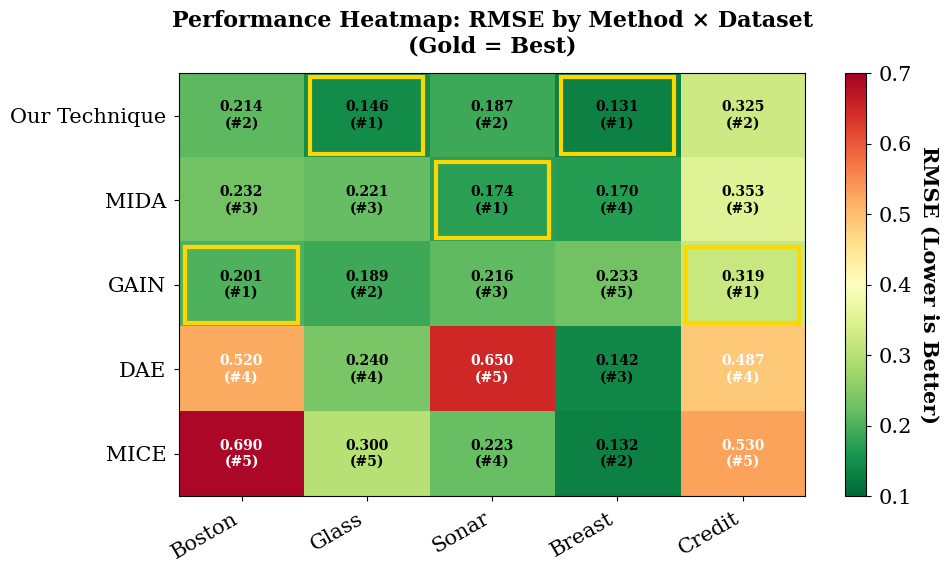


✓ ALL VISUALIZATIONS GENERATED SUCCESSFULLY!


In [10]:
# ============================================================================
# FIGURE 2: PERFORMANCE HEATMAP
# ============================================================================
fig2, ax = plt.subplots(figsize=(10, 6))

perf_matrix = np.array([methods_dict[m] for m in methods_dict.keys()])
rank_matrix = np.zeros_like(perf_matrix)
for j in range(perf_matrix.shape[1]):
    rank_matrix[:, j] = rankdata(perf_matrix[:, j])

im = ax.imshow(perf_matrix, cmap='RdYlGn_r', aspect='auto', vmin=0.1, vmax=0.7)
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('RMSE (Lower is Better)', rotation=270, labelpad=20, fontweight='bold')

ax.set_xticks(np.arange(len(datasets)))
ax.set_yticks(np.arange(len(methods_dict)))
ax.set_xticklabels(datasets, rotation=30, ha='right')
ax.set_yticklabels(methods_dict.keys())

for i in range(len(methods_dict)):
    for j in range(len(datasets)):
        rmse_val = perf_matrix[i, j]
        rank_val = int(rank_matrix[i, j])
        text_color = 'white' if rmse_val > 0.4 else 'black'
        ax.text(j, i, f'{rmse_val:.3f}\n(#{rank_val})',
               ha="center", va="center", color=text_color,
               fontsize=10, fontweight='bold')

        if rank_val == 1:
            rect = plt.Rectangle((j-0.45, i-0.45), 0.9, 0.9,
                                fill=False, edgecolor='gold', linewidth=3)
            ax.add_patch(rect)

ax.set_title('Performance Heatmap: RMSE by Method × Dataset\n(Gold = Best)',
             fontweight='bold', pad=15) #, fontsize=13

plt.tight_layout()
plt.savefig(os.path.join(output_folder, 'performance_heatmap_final.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(output_folder, 'performance_heatmap_final.pdf'), bbox_inches='tight')
print(f"✓ Saved: {os.path.join(output_folder, 'performance_heatmap_final.png')}/pdf")
plt.show()

print("\n" + "="*80)
print("✓ ALL VISUALIZATIONS GENERATED SUCCESSFULLY!")
print("="*80)

In [11]:
# ============================================================================
# FIGURE 1: 4-PANEL COMPREHENSIVE (Separate Panels to Individual PDFs)
# ============================================================================

# ---- Create full figure (for reference if needed) ----
# fig, axes = plt.subplots(2, 2, figsize=(14, 10))
#fig.suptitle('Statistical Analysis: Imputation Method Performance',
             #fontsize=16, fontweight='bold', y=0.995)

# Extract axes for convenience
ax1, ax2, ax3, ax4 = axes[0, 0], axes[0, 1], axes[1, 0], axes[1, 1]

# ============================================================================
# PANEL A: RMSE Trajectories
# ============================================================================
fig_a, ax1 = plt.subplots(figsize=(10, 8))
for method in methods_dict.keys():
    vals = methods_dict[method]
    marker = 'o' if method == 'Our Technique' else 's'
    lw = 2.5 if method == 'Our Technique' else 1.8
    ax1.plot(datasets, vals, marker=marker, label=method,
             linewidth=lw, color=colors[method], markersize=8 if method=='Our Technique' else 6)

for i, dataset in enumerate(datasets):
    min_rmse = min([methods_dict[m][i] for m in methods_dict.keys()])
    best = [m for m in methods_dict.keys() if methods_dict[m][i] == min_rmse][0]
    if best in ['Our Technique', 'GAIN', 'MIDA']:
        ax1.scatter(i, min_rmse, s=200, facecolors='none',
                   edgecolors='gold', linewidths=2.5, zorder=10)

ax1.set_xlabel('Dataset', fontweight='bold')
ax1.set_ylabel('RMSE', fontweight='bold')
ax1.set_title('RMSE Performance Across Datasets', fontweight='bold')
ax1.legend(loc='upper right', framealpha=0.9)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.tick_params(axis='x', rotation=30, labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
plt.savefig(os.path.join(output_folder, "figure1_panelA_RMSE_Trajectories.pdf"), bbox_inches='tight')
plt.savefig(os.path.join(output_folder, "figure1_panelA_RMSE_Trajectories.png"), dpi=300, bbox_inches='tight')
plt.close(fig_a)

# ============================================================================
# PANEL B: Mean Ranks
# ============================================================================
fig_b, ax2 = plt.subplots(figsize=(10, 8))
methods_order = rank_df['Method'].tolist()
colors_rank = [colors[m] for m in methods_order]
bars = ax2.barh(range(len(methods_order)), rank_df['Mean Rank'],
                color=colors_rank, alpha=0.8, edgecolor='black', linewidth=1.2)

for i, (idx, row) in enumerate(rank_df.iterrows()):
    ax2.text(row['Mean Rank'] + 0.1, i, f"{row['Mean Rank']:.2f}",
             va='center', fontweight='bold')
    ax2.text(1.35, i, f'#{i+1}', va='center', ha='right',
             fontweight='bold', color='gray')

ax2.set_yticks(range(len(methods_order)))
ax2.set_yticklabels(methods_order)
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax2.set_xlabel('Mean Rank (Lower is Better)', fontweight='bold')
ax2.set_title('Overall Performance Ranking', fontweight='bold') #, loc='left')
ax2.invert_yaxis()
ax2.grid(True, alpha=0.3, axis='x', linestyle='--')
ax2.set_xlim(0, 5)
plt.tight_layout()
plt.savefig(os.path.join(output_folder, "figure1_panelB_MeanRanks.pdf"), bbox_inches='tight')
plt.savefig(os.path.join(output_folder, "figure1_panelB_MeanRanks.png"), dpi=300, bbox_inches='tight')
plt.close(fig_b)

# ============================================================================
# PANEL C: Effect Sizes
# ============================================================================
fig_c, ax3 = plt.subplots(figsize=(10, 8))
baselines = ['MIDA', 'GAIN', 'DAE', 'MICE']
colors_effect = ['#27ae60' if e < -0.5 else '#2ecc71' if e < -0.3 else '#95a5a6' if e < 0
                 else '#ecf0f1' if e < 0.3 else '#e67e22' if e < 0.5 else '#e74c3c'
                 for e in effects]

bars = ax3.barh(baselines, effects, color=colors_effect,
                alpha=0.85, edgecolor='black', linewidth=1.2)

for i, (baseline, r) in enumerate(zip(baselines, effects)):
    x_pos = r + 0.05 if r > 0 else r - 0.05
    ha = 'left' if r > 0 else 'right'
    ax3.text(x_pos, i, f'{r:+.2f}', va='center', ha=ha, fontweight='bold')

ax3.axvline(x=0, color='black', linestyle='-', linewidth=2)
ax3.axvline(x=-0.3, color='green', linestyle=':', alpha=0.6, linewidth=1.5)
ax3.axvline(x=-0.5, color='green', linestyle='--', alpha=0.6, linewidth=1.5)
ax3.axvline(x=0.3, color='red', linestyle=':', alpha=0.6, linewidth=1.5)

ax3.tick_params(axis='x', labelsize=14)
ax3.tick_params(axis='y', labelsize=14)
ax3.set_xlabel('Rank-Biserial Correlation (r)', fontweight='bold')
ax3.set_title('Effect Sizes: Our Technique vs. Baselines', fontweight='bold') #, loc='left')
ax3.grid(True, alpha=0.3, axis='x', linestyle='--')
ax3.set_xlim(-1.2, 0.7)
ax3.text(0.78, 0.98, '− = Our Technique Better\n+ = Baseline Better',
         transform=ax3.transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5)) #, fontsize=9
plt.tight_layout()
plt.savefig(os.path.join(output_folder, "figure1_panelC_EffectSizes.pdf"), bbox_inches='tight')
plt.savefig(os.path.join(output_folder, "figure1_panelC_EffectSizes.png"), dpi=300, bbox_inches='tight')
plt.close(fig_c)

# ============================================================================
# PANEL D: Boxplots
# ============================================================================
fig_d, ax4 = plt.subplots(figsize=(10, 10))
data_box = [methods_dict[m] for m in methods_order]
bp = ax4.boxplot(data_box, positions=range(len(methods_order)), patch_artist=True,
                 widths=0.6, showmeans=True, meanline=True,
                 boxprops=dict(linewidth=1.5, edgecolor='black'),
                 whiskerprops=dict(linewidth=1.5),
                 capprops=dict(linewidth=1.5),
                 medianprops=dict(linewidth=2, color='red'),
                 meanprops=dict(linewidth=2, color='blue', linestyle='--'))

for i, (box, method) in enumerate(zip(bp['boxes'], methods_order)):
    box.set_facecolor(colors[method])
    box.set_alpha(0.7)

for i, (method, values) in enumerate(zip(methods_order, data_box)):
    x = np.random.normal(i, 0.04, size=len(values))
    ax4.scatter(x, values, alpha=0.6, s=50, color='black', zorder=10)

ax4.set_xticks(range(len(methods_order)))
ax4.set_xticklabels(methods_order, rotation=30, ha='right', fontweight='bold')
ax4.tick_params(axis='x', labelsize=14)
ax4.tick_params(axis='y', labelsize=14)
ax4.set_ylabel('RMSE', fontweight='bold')
ax4.set_title('RMSE Distribution by Method', fontweight='bold') #, loc='left')
ax4.grid(True, alpha=0.3, axis='y', linestyle='--')
ax4.plot([], [], 'r-', linewidth=2, label='Median')
ax4.plot([], [], 'b--', linewidth=2, label='Mean')
ax4.legend(loc='upper left')#, fontsize=9)
plt.tight_layout()
plt.savefig(os.path.join(output_folder, "figure1_panelD_Boxplots.pdf"), bbox_inches='tight')
plt.savefig(os.path.join(output_folder, "figure1_panelD_Boxplots.png"), dpi=300, bbox_inches='tight')
plt.close(fig_d)


print(f"✓ Saved individual PDFs to '{output_folder}':")
print(f"  - {os.path.join(output_folder, 'figure1_panelA_RMSE_Trajectories.pdf')}")
print(f"  - {os.path.join(output_folder, 'figure1_panelB_MeanRanks.pdf')}")
print(f"  - {os.path.join(output_folder, 'figure1_panelC_EffectSizes.pdf')}")
print(f"  - {os.path.join(output_folder, 'figure1_panelD_Boxplots.pdf')}")

✓ Saved individual PDFs to '/content/drive/MyDrive/MIDA-our/Results/figures':
  - /content/drive/MyDrive/MIDA-our/Results/figures/figure1_panelA_RMSE_Trajectories.pdf
  - /content/drive/MyDrive/MIDA-our/Results/figures/figure1_panelB_MeanRanks.pdf
  - /content/drive/MyDrive/MIDA-our/Results/figures/figure1_panelC_EffectSizes.pdf
  - /content/drive/MyDrive/MIDA-our/Results/figures/figure1_panelD_Boxplots.pdf




10. SPEARMAN CORRELATION ANALYSIS (ρ)
--------------------------------------------------------------------------------
Spearman’s ρ (rho): 0.738
p-value: 0.1546
Saved correlation plot to 'spearman_rho_analysis.png'
Interpretation: A positive ρ indicates stronger batch evidence correlates with larger performance improvements.


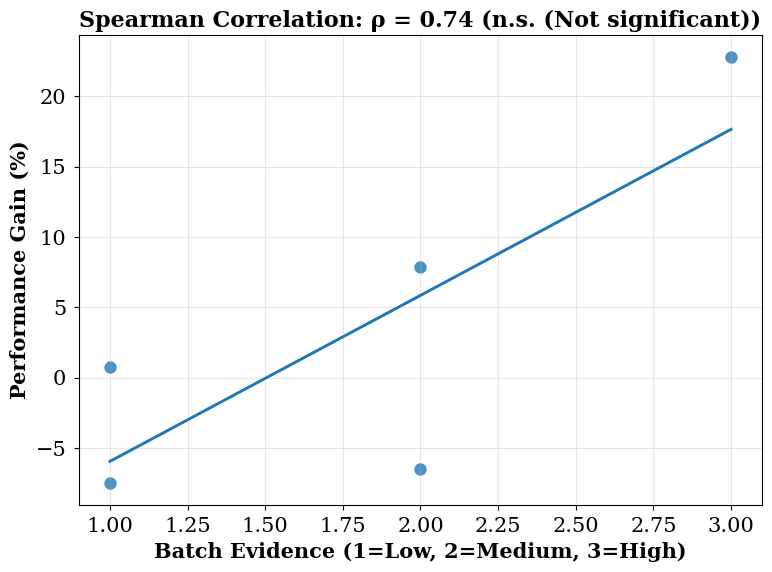

In [12]:
# =============================================================================
# 10. SPEARMAN CORRELATION ANALYSIS (ρ)
# =============================================================================
print("\n\n10. SPEARMAN CORRELATION ANALYSIS (ρ)")
print("-" * 80)

# Example: Batch Evidence vs Performance Gain (%)
# -----------------------------------------------
# Assign numeric batch evidence levels (e.g., 1=Low, 2=Medium, 3=High)
batch_evidence = np.array([2, 3, 1, 1, 2])   # [Boston, Glass, Sonar, Breast, Credit]
performance_gain = np.array([-6.5, 22.8, -7.5, 0.8, 7.9])  # % difference vs best baseline

# Compute Spearman correlation (non-parametric rank-based)
rho, p_rho = spearmanr(batch_evidence, performance_gain)

print(f"Spearman’s ρ (rho): {rho:.3f}")
print(f"p-value: {p_rho:.4f}")

# Interpret results
if p_rho < 0.001:
    sig_label = "*** (Highly significant)"
elif p_rho < 0.01:
    sig_label = "** (Significant)"
elif p_rho < 0.05:
    sig_label = "* (Marginally significant)"
else:
    sig_label = "n.s. (Not significant)"

# Simple visual check
plt.figure(figsize=(8, 6))
sns.regplot(x=batch_evidence, y=performance_gain, ci=None, scatter_kws={'s': 80})
plt.title(f"Spearman Correlation: ρ = {rho:.2f} ({sig_label})", fontweight="bold")
plt.xlabel("Batch Evidence (1=Low, 2=Medium, 3=High)", fontweight="bold")
plt.ylabel("Performance Gain (%)", fontweight="bold")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("spearman_rho_analysis.png", dpi=300, bbox_inches="tight")

print(f"Saved correlation plot to 'spearman_rho_analysis.png'")
print(f"Interpretation: A positive ρ indicates stronger batch evidence correlates "
      f"with larger performance improvements.")